 - __Import base modules__

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

 - __Import sklearn modules__

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.model_selection import learning_curve
from sklearn.metrics import recall_score, confusion_matrix, classification_report
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold
import time
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
from imblearn import under_sampling, over_sampling
from imblearn.over_sampling import SMOTE

Using TensorFlow backend.


 - __Import TfidfVectorizer__

In [3]:
from sklearn.feature_extraction.text import TfidfVectorizer

 - __Import the spam/ham dataset__

In [4]:
url="https://raw.githubusercontent.com/arimitramaiti/datasets/master/Classification/spam_ham_text_classification.csv"
dataset = pd.read_csv(url, error_bad_lines=False, header=0)
dataset.head(4)

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...


 - __Check if missing values exist__

In [5]:
dataset.isnull().sum()

Category    0
Message     0
dtype: int64

 - __Check proportion of class values__
 - __Yes, fair imbalance exists__

In [6]:
dataset.Category.value_counts()

ham     4825
spam     747
Name: Category, dtype: int64

 - __Check is NaN values are there and if yes then collect row indices__

In [7]:
blanks = []
for index, label, review in dataset.itertuples():
    if type(review)==str:
        if review.isspace():
            blanks.append(index)
        
print(len(blanks), 'blanks: ', blanks)

0 blanks:  []


 - __Apply TF-IDF method including stop words, maximum & minimum document frequency threshold__

In [8]:
vectorizer = TfidfVectorizer(stop_words='english', max_df=0.90, min_df=2)

 - __Fit and transform on review data__

In [9]:
X = vectorizer.fit_transform(dataset['Message'])
X.shape

(5572, 3955)

In [10]:
y = dataset['Category']
y.shape

(5572,)

In [11]:
sdict = {'spam': 1, 'ham': 0}
y = y.map(sdict)

 - __Create training and testing datasets__

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, stratify=y, random_state=123)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((3900, 3955), (1672, 3955), (3900,), (1672,))

In [13]:
print("Before OverSampling, counts of label '1': {}".format(sum(y_train == 1))) 
print("Before OverSampling, counts of label '0': {} \n".format(sum(y_train == 0)))

Before OverSampling, counts of label '1': 523
Before OverSampling, counts of label '0': 3377 



 - __Apply SMOTE to uplift class imbalance only in training data__

In [14]:
sm = SMOTE(random_state = 2) 
X_train_res, y_train_res = sm.fit_sample(X_train, y_train.ravel())

In [15]:
print("After OverSampling, counts of label '1': {}".format(sum(y_train_res == 1))) 
print("After OverSampling, counts of label '0': {}".format(sum(y_train_res == 0)))
X_train_res.shape, X_test.shape, y_train_res.shape, y_test.shape

After OverSampling, counts of label '1': 3377
After OverSampling, counts of label '0': 3377


((6754, 3955), (1672, 3955), (6754,), (1672,))

 - __Import Light GBM module__

In [16]:
import lightgbm as lgb

 - __Declare estimator__

In [17]:
estimator = lgb.LGBMClassifier(boosting_type ="goss", random_state=1)

 - __Declare a decimal range of learning rates__
 - __Declare a range of tree counts__
 - __Declare a set of max depth values__
 - __Declare a set of minimum child weight__
 - __Declare a set of sample proportions to be used in attribute sampling__
 - __Create dictionary which is a must for Random Search function__

In [18]:
learning_rate = np.arange(0.01,1,0.05)
n_estimators = np.arange(100, 500, 50)
max_depth = [2, 5, 10, 20, 30, 40, 50]
min_child_weight = [1,3,6]
colsample_bytree = [0.1, 0.5, 0.8, 1]
num_leaves = [300, 900, 1200]

param_grid = {'learning_rate': learning_rate,
              'n_estimators': n_estimators,
              'max_depth': max_depth,
              'min_child_weight': min_child_weight,
              'colsample_bytree': colsample_bytree,
              'num_leaves': num_leaves}

 - __Instantiate the RandomizedSearchCV object with accuracy as scoring metric__
 - __Push the parameter dictionary inside the object__

In [19]:
randomized_accuracy_fit = RandomizedSearchCV(estimator=estimator,
                                            param_distributions=param_grid,
                                            n_iter=50,
                                            scoring="accuracy",
                                            n_jobs=-1,
                                            refit=True,
                                            random_state=123,
                                            return_train_score=True,
                                            verbose=1,
                                            cv=StratifiedKFold(n_splits=10, shuffle=True, random_state=123)
                                            )

 - __Fit the RandomizedSearchCV object on X_train & y_train__

In [20]:
training_start = time.perf_counter()
randomized_accuracy_fit.fit(X_train_res, y_train_res)
training_end = time.perf_counter()
lgb_train_time = training_end-training_start
print("Time consumed for training: %4.3f seconds" % (lgb_train_time))

Fitting 10 folds for each of 50 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   36.0s
C:\Users\Debjani\anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  5.5min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  6.2min finished


Time consumed for training: 371.895 seconds


 - __Print the best score found by RandomizedSearchCV__
 - __Print the best model found by RandomizedSearchCV__

In [21]:
print(randomized_accuracy_fit.best_score_)
print(randomized_accuracy_fit.best_estimator_)

0.98697150997151
LGBMClassifier(boosting_type='goss', class_weight=None, colsample_bytree=0.8,
               importance_type='split', learning_rate=0.36000000000000004,
               max_depth=5, min_child_samples=20, min_child_weight=1,
               min_split_gain=0.0, n_estimators=200, n_jobs=-1, num_leaves=300,
               objective=None, random_state=1, reg_alpha=0.0, reg_lambda=0.0,
               silent=True, subsample=1.0, subsample_for_bin=200000,
               subsample_freq=0)


 - __Store the best model in an object__
 - __Create predictions from the best model__

In [22]:
best_estimator = randomized_accuracy_fit.best_estimator_
prediction_start = time.perf_counter()
y_pred = best_estimator.predict(X_test)
prediction_end = time.perf_counter()
lgb_prediction_time = prediction_end-prediction_start
print("Time consumed for prediction: %6.5f seconds" % (lgb_prediction_time))

Time consumed for prediction: 0.01547 seconds


 - __Calculate Accuracy and Recall Scores__
 - __Print the respective values__
 - __Create confusion matrix and print it using heatmap__

The accuracy score for the model is: 0.977
The recall score for the model is: 0.936
              precision    recall  f1-score   support

           0       0.98      0.99      0.99      1448
           1       0.95      0.88      0.91       224

    accuracy                           0.98      1672
   macro avg       0.96      0.94      0.95      1672
weighted avg       0.98      0.98      0.98      1672



Text(91.68, 0.5, 'Actual')

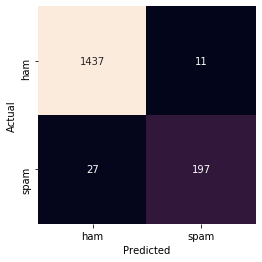

In [23]:
acc = round(accuracy_score(y_test, y_pred),3)
rec = round(recall_score(y_test, y_pred, average="macro"), 3)
cre = classification_report(y_test,y_pred)
print("The accuracy score for the model is: {}".format(acc))
print("The recall score for the model is: {}".format(rec))
print(cre)
met = confusion_matrix(y_test, y_pred)
sns.heatmap(met, square=True, annot=True, fmt="d", cbar=False, xticklabels=['ham', 'spam'], yticklabels=['ham', 'spam'])
plt.xlabel("Predicted")
plt.ylabel("Actual")